In [1]:
import numpy as np
#import matplotlib.pyplot as plt
import corner
import emcee
from invisoplanet_detection.statistics import *

In [2]:
def run_MCMC(filepath, known_bodies, unknown_bodies, num_dim, surrogate_points = 9, num_iter_likelihood = 20000, 
             time_step = 0.5, last_n = 100, num_walker = 16, num_iter_MCMC = 5000, init_guess_factor_1 = 2, 
             init_guess_factor_2 = 2, discard = 500, thin = 10):

    #Retrieve mass of unknown bodies:
    with open(filepath, "r") as file:
        ics = json.load(file)
    unknown_masses_list = []
    for i, body in enumerate(ics["bodies"]):
        if i >= known_bodies:
            mass = body["mass"]
            unknown_masses_list.append(mass)
    
    #Define max_masses from the unknown_masses list:
    max_masses = np.array(unknown_masses_list, dtype = float) * 100
    max_masses[max_masses == 0] = 0.001
    
    #Construct the likelihood:
    likelihood = Likelihood(known_bodies, unknown_bodies, filepath, max_masses, surrogate_points, num_iter_likelihood, 
                            time_step, last_n)

    #Define initial positions for the walkers for MCMC:
    if unknown_bodies == 1 and num_dim == 1: #Running MCMC for 1 unknown body
        array = np.array([max_masses[0]/100*init_guess_factor_1])
    elif unknown_bodies == 1 and num_dim == 2: #Running MCMC for 1 unknown body and eta
        array = np.array([[max_masses[0]/100*init_guess_factor_1, 0],[0, 1]])
    elif unknown_bodies == 2 and num_dim == 2: #Running MCMC for 2 unknown bodies
        array = np.array([[max_masses[0]/100*init_guess_factor_1, 0],[0, max_masses[1]/100*init_guess_factor_2]])
    elif unknown_bodies == 2 and num_dim == 3: #Running MCMC for 2 unknown bodies and eta
        array = np.array([[max_masses[0]/100*init_guess_factor_1, 0, 0],[0, max_masses[1]/100*init_guess_factor_2, 0],[0, 0, 1]])
    else:
        return likelihood.hardcorded_error_message()
    init_pos = np.random.rand(num_walker, num_dim) @ array
    
    #Run the MCMC
    if num_dim == unknown_bodies:
        likelihood.set_eta(1)
        sampler = emcee.EnsembleSampler(num_walker, num_dim, likelihood.log_posterior)
        sampler.run_mcmc(init_pos, num_iter_MCMC, progress=True);
    else:
        sampler = emcee.EnsembleSampler(num_walker, num_dim, likelihood.log_posterior_variable_eta)
        sampler.run_mcmc(init_pos, num_iter_MCMC, progress=True);
    
    return sampler.get_chain(), sampler.get_chain(discard = discard, thin = thin, flat = True)

In [4]:
#Running the "toy model" systems to test the run-time and convergence of the MCMC
samples_SUN_JUP, flat_SUN_JUP = run_MCMC("invisoplanet_detection/data/sun_jup_2_0_1.json", 2, 1, 2)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 69.20it/s]


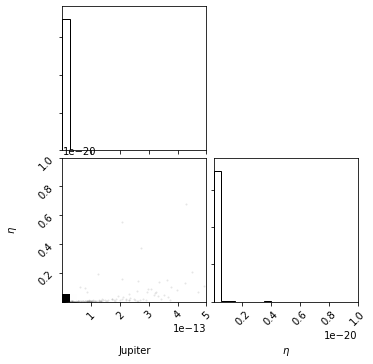

In [9]:
fig_SUN_JUP = corner.corner(flat_SUN_JUP, range = [(0, 5e-13), (0, 1e-20)], labels = ['Jupiter', r'$\eta$']);

In [11]:
samples_SUN_JUP_sat, flat_SUN_JUP_sat = run_MCMC("invisoplanet_detection/data/sun_jup_sat_2_1_1.json", 2, 1, 2)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:52<00:00, 95.57it/s]


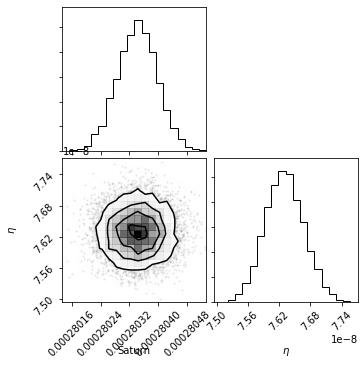

In [12]:
fig_SUN_JUP_sat = corner.corner(flat_SUN_JUP_sat, labels = ['Saturn', r'$\eta$']);

In [17]:
samples_SAT_sun_jup, flat_SAT_sun_jup = run_MCMC("invisoplanet_detection/data/sat_sun_jup_1_2_2.json", 1, 2, 2, init_guess_factor_1 = 50, init_guess_factor_2 = 50, num_iter_MCMC = 10000, num_iter_likelihood = 40000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:44<00:00, 29.06it/s]


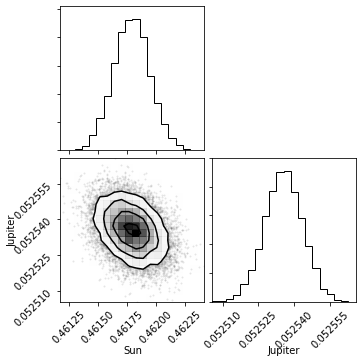

In [18]:
fig_SAT_sun_jup = corner.corner(flat_SAT_sun_jup, labels = ['Sun', 'Jupiter'])

In [3]:
samples_SAT_sun_jup_dif_IC, flat_SAT_sun_jup_dif_IC = run_MCMC("invisoplanet_detection/data/sat_sun_jup_1_2_2.json", 1, 2, 2, init_guess_factor_1 = 50, init_guess_factor_2 = 1, num_iter_MCMC = 10000, num_iter_likelihood = 40000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:08<00:00, 53.19it/s]


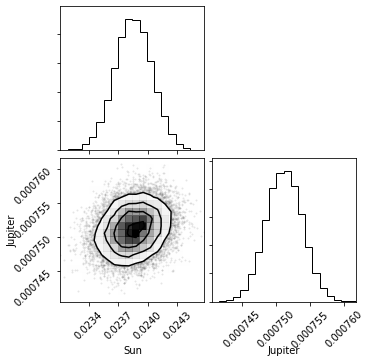

In [9]:
fig_SAT_sun_jup_dif_IC = corner.corner(flat_SAT_sun_jup_dif_IC, labels = ['Sun', 'Jupiter'])

In [6]:
samples_SAT_sun_jup_eta, flat_SAT_sun_jup_eta = run_MCMC("invisoplanet_detection/data/sat_sun_jup_1_2_2.json", 1, 2, 3, num_iter_MCMC = 10000, num_iter_likelihood = 40000, init_guess_factor_1 = 50, init_guess_factor_2 = 50)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:05<00:00, 40.74it/s]


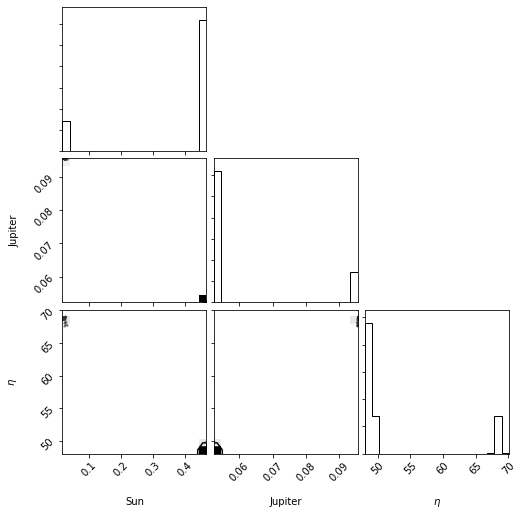

In [8]:
fig_SAT_sun_jup_eta = corner.corner(flat_SAT_sun_jup_eta, labels = ['Sun', 'Jupiter', r'$\eta$'])

In [3]:
#Going crazy with our systems and modelling the whole solar system!
samples_SOLAR_SYSTEM_sun, flat_SOLAR_SYSTEM_sun = run_MCMC("invisoplanet_detection/data/solar_system_8_1_1.json", 8, 1, 2, num_iter_likelihood = 100000, num_iter_MCMC = 30000)

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [5:36:04<00:00,  1.49it/s]


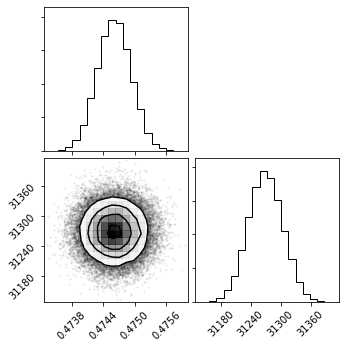

In [6]:
fig_SOLAR_SYSTEM_sun = corner.corner(flat_SOLAR_SYSTEM_sun)

In [4]:
#Testing the limits of the code:
samples_SOLAR_SYSTEM_pluto, flat_SOLAR_SYSTEM_pluto = run_MCMC("invisoplanet_detection/data/solar_system_pluto_9_1_1.json", 9, 1, 2, num_iter_likelihood = 50000, num_iter_MCMC = 20000)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [2:08:12<00:00,  2.60it/s]


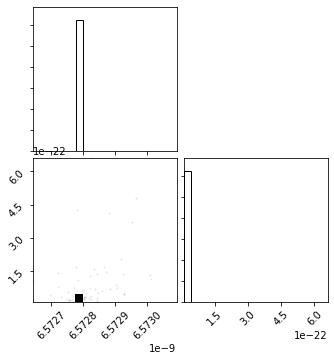

In [7]:
fig_SOLAR_SYSTEM_pluto = corner.corner(flat_SOLAR_SYSTEM_pluto)

In [ ]:
samples_MOON_EARTH_JUP_sun, flat_MOON_EARTH_JUP_sun = run_MCMC("invisoplanet_detection/data/moon_earth_jup_sun_3_1_1.json", 3, 1, 2, num_iter_likelihood = 50000, num_iter_MCMC = 20000)